# AIE6211 NLP 1st Assignment - Neural Machine Translation by Jointly Learning to Align and Translate
### <div style="text-align: right"> 120220224 정원 </div>

[Colab Example Github Link](https://github.com/bentrevett/pytorch-seq2seq)

In this third notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473). This model achives our best perplexity yet, ~27 compared to ~34 for the previous model.

## Dependency
torchtext=0.11.0 버전을 받을 경우 dependency에 따라 자동으로 torch=1.10.1+cu102를 설치하게 됨

이 때 torch 1.10.1 버전의 경우 cuda 10.2 & gcc 8 버전과 호환

RTX 3090 GPU의 경우 cuda 11버전부터만 동작하여 torchtext 이전 버전을 사용할 수 없다.

## Introduction

이번에 분석할 Neural Machine Translation by Jointly Learning to Align and Translate 논문은 기존 번역 모델에서 사용하던 Encoder-Decoder 구조에 attention 개념을 추가하여 input sentence의 전체적인 정보를 context vector에 담을 수 있도록 한다.

아래 그림은 기존의 일반적인 encoder-decoder model이다.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq1.png?raw=1)

Context vector $z$가 input sentence의 마지막 단어 블록을 통해 추출된 정보만을 $z$의 input으로 사용하기 때문에 문장이 길어질 경우 앞선 단어의 정보가 많이 희석되는 문제가 있었다.

아래 그림은 decoder 단에서 모든 token을 예측할 때 context vector를 input 중 하나로 사용하여 보다 정확한 예측값을 얻게하는 모델 구조이다.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq7.png?raw=1)

하지만 이러한 모델 또한 source 문장의 마지막 block 정보만을 context vector $z$에 싣게 된다는 단점은 그대로 존재한다. 이를 해결하기 위해 논문에서는 attention이라는 개념을 도입했고 source 문장의 모든 token의 정보를 가지고 있으며 softmax를 통해 각 요소가 0과 1 사이, 총합이 1이 되는 attention vector, $a$를 다음 token을 예측할 때 함께 사용하게 된다. 

$$w = \sum_{i}a_ih_i$$

![](https://github.com/mallang327/AIE6211_NLP/blob/main/resources/nmt_image.png?raw=1)


## Preparing Data



In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time
import pdb

학습시간을 확인하기 위해 tqdm import

In [54]:
torch.__version__
from tqdm.auto import tqdm

Set the random seeds for reproducability.

SEED 고정을 통해 초기값을 동일하게 만들어 항상 같은 결과를 재현할 수 있도록 한다.

In [55]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Load the German and English spaCy models.

#### Tokenizer
Tokenizer 모델을 다운로드하는 코드를 추가한다. 여기에서는 독일어와 영어 tokenizer를 사용한다

* spaCy Tokenizer의 토큰화 과정

![](https://github.com/mallang327/AIE6211_NLP/blob/main/resources/tokenizer_image.png?raw=1)

In [56]:
#import locale
#locale.getpreferredencoding = lambda: "UTF-8"
#!python -m spacy download en_core_web_sm
#!python -m spacy download de_core_news_sm

In [57]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

We create the tokenizers.

spacy_de, spacy_en으로 tokenize된 token의 리스트를 반환하는 메소드

In [58]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

The fields remain the same as before.

torchtext의 Field 함수를 이용하여

1) tokenize_de, tokenize_en 함수로 각각 토큰화 

1) Token list (Sentence)의 시작을 $<sos>$, 끝을 $<eos>$로 통일

1) 모든 token을 소문자화시킨다

In [59]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

Load the data.

#### Multi30K: Multilingual English-German Image Descriptions

train: 29,000 sentences / val: 1,014 sentences / test: 1,000 sentences each

![](https://github.com/mallang327/AIE6211_NLP/blob/main/resources/multi30k_des.JPG?raw=1)

In [60]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

Build the vocabulary.

실제 데이터 개수를 len을 이용해 확인해보면 위와 같다는 것을 알 수 있다.

In [61]:
len(train_data), len(valid_data), len(test_data)

(29000, 1014, 1000)

In [62]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Define the device.

특정 GPU를 사용하기 위해 device는 cuda:1로 임의로 바꿔주었다.

In [63]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

Create the iterators.

torch의 DataLoader와 마찬가지로 torchtext에 있는 BucketIterator를 사용해 학습에 사용할 Iterator를 생성한다.

Batch size는 128로 한번 iteration이 돌 때마다 128 묶음의 데이터를 병렬로 사용하게 된다.

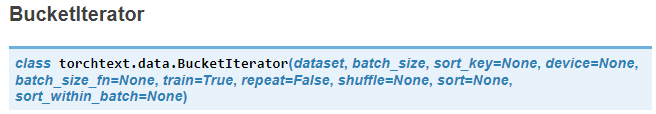

BucketIterator는 비슷한 길이의 단어를 하나의 batch 안에 묶어주는 역할을 한다.

RNN의 경우 하나의 batch안에 들어가는 input sequence의 길이가 동일해야하기 때문에 padding을 이용한 collate 과정 거치게 된다.

이 때 단어의 길이가 비슷할 수록 padding하는 size를 최소화할 수 있다.

In [64]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

## Building the Seq2Seq Model

### Encoder

문장에서 token끼리의 앞 뒤 문맥을 파악할 수 있도록 단방향 RNN이 아닌 양방향 RNN을 사용한다.

RNN 구조는 GRU block을 사용하여 단순 RNN block에 비해 앞선 단어 정보를 더 기억할 수 있도록 한다.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq8.png?raw=1)


$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

### nn.Embedding
num_embeddings과 embedding_dim을 인자로 받는다.

num_embeddings : embedding할 단어들의 개수, input 단어 집합의 크기

현재 **input_dim** 변수에 저장 --> len(SRC.vocab): $7853$

embedding_dim : embedding할 벡터의 차원

현재 **emb_dim** 변수에 저장 --> 256

In [130]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):

        ##print(f"src shape: {src.shape}\n{src}")
        embedded = self.dropout(self.embedding(src))
        ##print(f"\nembedded shape: {embedded.shape}\n{embedded}")
        
        outputs, hidden = self.rnn(embedded)
        ##print(f"\nGRU output shape: {outputs.shape}\n{outputs}")
        ##print(f"\nGRU hidden shape: {hidden.shape}\n{hidden}")

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        ##print(f"\nBidirectional --> single hidden shape: {hidden.shape}\n{hidden}")
        
        return outputs, hidden

### Encoder Block Parameter Analysis

In [131]:
# SRC: 독일어 / TRG: 영어
len(SRC.vocab), len(TRG.vocab)

(7853, 5893)

In [132]:
INPUT_DIM = len(SRC.vocab)
ENC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT).to(device)

In [113]:
for i, batch in enumerate(train_iterator):
    src = batch.src #src = [src len, batch size] ex) [28, 128]
    encoder_outputs, hidden = enc(src)
    # for testing only single case
    if i == 0:
        break

src shape: torch.Size([30, 128])
tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [  8,  43,  54,  ...,  18,   5,   5],
        [ 16,  41, 548,  ...,  30,  13,  13],
        ...,
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]], device='cuda:1')

embedded shape: torch.Size([30, 128, 256])
tensor([[[ 0.0000,  0.0000,  0.0000,  ..., -2.7541, -2.4462,  1.0542],
         [ 0.4369, -0.2305,  0.0000,  ...,  0.0000,  0.0000,  1.0542],
         [ 0.0000,  0.0000,  0.0000,  ..., -2.7541, -2.4462,  1.0542],
         ...,
         [ 0.4369,  0.0000,  0.5429,  ..., -2.7541, -2.4462,  1.0542],
         [ 0.4369, -0.2305,  0.0000,  ...,  0.0000,  0.0000,  1.0542],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -2.4462,  0.0000]],

        [[ 0.0000,  0.0000, -1.2003,  ...,  0.0000, -4.1245,  2.2230],
         [ 0.0000,  0.0000, -2.0029,  ...,  0.0000,  0.0000, -1.4674],
         [-3.2512,  5.3258, -2.7

#### Parameter shape info

src = [src len, batch size]

Embedded = [src len, batch size, emb dim]

GRU output = [src len, batch size, ENC_HID_DIM * num directions]

GRU hidden = [n layers * num directions, batch size, ENC_HID_DIM]

Bidirectional GRU의 hidden은 [forward_1, backward_1, forward_2, backward_2, ...]로 forward와 backward가 순차적으로 리스트에 저장된다.

$torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))$를 통해 forward path의 마지막 RNN output과 backward path의 마지막 RNN output을 concatenate한 후 512차원으로 FC layer 학습

마지막 hidden output = fc & tanh output --> [batch size, DEC_HID_DIM]

### Attention

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

$$\hat{a}_t = v E_t$$

$$a_t = \text{softmax}(\hat{a_t})$$

$energy = torch.tanh(self.attn(torch.cat((hidden, encoder\_outputs), dim = 2)))$

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq9.png?raw=1)

In [133]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

### Decoder

Next up is the decoder. 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The embedded input word, $d(y_t)$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $d(y_t)$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

We then pass $d(y_t)$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq10.png?raw=1)

The green/teal blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [134]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim) # Encoder의 GRU: self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        #print(f"unsqueezed input shape: {input.shape}\n{input}")
        embedded = self.dropout(self.embedding(input))
        #print(f"embedded shape: {embedded.shape}\n{embedded}") #embedded = [1, batch size, DEC_EMB_DIM]        
        a = self.attention(hidden, encoder_outputs) #a = [batch size, src len]
        a = a.unsqueeze(1) #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2) #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs) #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2) #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2) #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

### Decoder Block Parameter Analysis

In [135]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM).to(device)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn).to(device)

for i, batch in enumerate(train_iterator):
    src = batch.src #src = [src len, batch size] ex) [28, 128]
    trg = batch.trg #trg = [trg len, batch size] ex) [30, 128]
    encoder_outputs, hidden = enc(src) 
    # encoder_outputs = [src len, batch size, ENC_HID_DIM * num directions] ex) [28, 128, 1024]
    # hidden = [batch size, DEC_HID_DIM] ex) [128, 512]
    
    input = trg[0,:] # 시작 단어 <sos> token의 embedding
    trg_len = trg.shape[0]
    for t in range(1, trg_len):
        output, hidden = dec(input, hidden, encoder_outputs)
        
    # for testing only single case
    if i == 0:
        break

Output이 최종 토큰의 확률

In [128]:
output.shape, output

(torch.Size([128, 5893]),
 tensor([[-0.0287, -0.4831,  0.0305,  ...,  0.4108,  0.2089, -0.1726],
         [ 0.2814,  0.0523, -0.0680,  ..., -0.2732,  0.1958, -0.0284],
         [ 0.0261, -0.1284,  0.3701,  ..., -0.0697,  0.0504,  0.2124],
         ...,
         [ 0.2879,  0.0019,  0.0092,  ..., -0.0212,  0.1291,  0.1890],
         [-0.1548,  0.0165,  0.0372,  ...,  0.4491, -0.0099,  0.1772],
         [ 0.2439,  0.0461, -0.1519,  ..., -0.3080,  0.4046,  0.0213]],
        device='cuda:1', grad_fn=<AddmmBackward0>))

In [126]:
hidden.shape, hidden

(torch.Size([128, 512]),
 tensor([[-0.7538,  0.0189,  0.2725,  ...,  0.3231,  0.3392, -0.1014],
         [-0.7906,  0.3478,  0.5368,  ..., -0.1710,  0.5614,  0.3092],
         [-0.6204, -0.1625,  0.1681,  ..., -0.4039,  0.3754,  0.2851],
         ...,
         [-0.7595,  0.0891,  0.5427,  ..., -0.2164,  0.2249,  0.3600],
         [-0.7105, -0.1476,  0.0401,  ..., -0.0728,  0.3609, -0.2611],
         [-0.6738, -0.1942,  0.3818,  ...,  0.1910,  0.5897, -0.0253]],
        device='cuda:1', grad_fn=<SqueezeBackward1>))

### Seq2Seq

This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`. 

This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the decoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

In [165]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        if trg is None:
            trg = torch.zeros((25, src.shape[1])).fill_(2).long().to(src.device)
            assert teacher_forcing_ratio == 0, "Must be zero during inference"         
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model

The rest of this tutorial is very similar to the previous one.

We initialise our parameters, encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [166]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [157]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Calculate the number of parameters. We get an increase of almost 50% in the amount of parameters from the last model. 

In [158]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


We create an optimizer.

In [159]:
optimizer = optim.Adam(model.parameters())

We initialize the loss function.

In [160]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

We then create the training loop...

In [161]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [162]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Finally, define a timing function.

In [163]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

#### Validation loss가 가장 작아지는 순간의 weight를 "tut3-model.pt"에 저장

In [164]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

tr_loss = []
va_loss = []
tr_ppls = []
va_ppls = []
for epoch in tqdm(range(N_EPOCHS)):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './checkpoint/tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    tr_loss.append(train_loss); va_loss.append(valid_loss)
    tr_ppls.append(math.exp(train_loss)); va_ppls.append(math.exp(valid_loss))

 10%|███████▍                                                                  | 1/10 [00:38<05:43, 38.12s/it]

Epoch: 01 | Time: 0m 37s
	Train Loss: 5.048 | Train PPL: 155.743
	 Val. Loss: 5.076 |  Val. PPL: 160.087


 20%|██████████████▊                                                           | 2/10 [01:16<05:06, 38.27s/it]

Epoch: 02 | Time: 0m 37s
	Train Loss: 4.161 | Train PPL:  64.125
	 Val. Loss: 4.449 |  Val. PPL:  85.510


 30%|██████████████████████▏                                                   | 3/10 [01:55<04:29, 38.49s/it]

Epoch: 03 | Time: 0m 37s
	Train Loss: 3.490 | Train PPL:  32.770
	 Val. Loss: 3.808 |  Val. PPL:  45.066


 40%|█████████████████████████████▌                                            | 4/10 [02:34<03:52, 38.76s/it]

Epoch: 04 | Time: 0m 38s
	Train Loss: 2.939 | Train PPL:  18.898
	 Val. Loss: 3.440 |  Val. PPL:  31.172


 50%|█████████████████████████████████████                                     | 5/10 [03:13<03:14, 38.89s/it]

Epoch: 05 | Time: 0m 38s
	Train Loss: 2.529 | Train PPL:  12.544
	 Val. Loss: 3.285 |  Val. PPL:  26.708


 60%|████████████████████████████████████████████▍                             | 6/10 [03:53<02:36, 39.10s/it]

Epoch: 06 | Time: 0m 38s
	Train Loss: 2.230 | Train PPL:   9.300
	 Val. Loss: 3.205 |  Val. PPL:  24.655


 70%|███████████████████████████████████████████████████▊                      | 7/10 [04:32<01:57, 39.20s/it]

Epoch: 07 | Time: 0m 38s
	Train Loss: 1.992 | Train PPL:   7.327
	 Val. Loss: 3.197 |  Val. PPL:  24.461


 80%|███████████████████████████████████████████████████████████▏              | 8/10 [05:10<01:17, 38.88s/it]

Epoch: 08 | Time: 0m 38s
	Train Loss: 1.797 | Train PPL:   6.034
	 Val. Loss: 3.238 |  Val. PPL:  25.482


 90%|██████████████████████████████████████████████████████████████████▌       | 9/10 [05:48<00:38, 38.62s/it]

Epoch: 09 | Time: 0m 38s
	Train Loss: 1.635 | Train PPL:   5.128
	 Val. Loss: 3.266 |  Val. PPL:  26.212


100%|█████████████████████████████████████████████████████████████████████████| 10/10 [06:26<00:00, 38.69s/it]

Epoch: 10 | Time: 0m 38s
	Train Loss: 1.501 | Train PPL:   4.488
	 Val. Loss: 3.349 |  Val. PPL:  28.467


Finally, we test the model on the test set using these "best" parameters.

#### Loss & PPL Graph

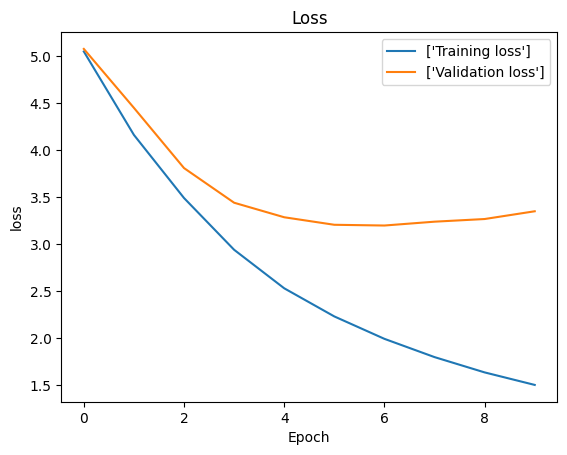

In [167]:
import matplotlib.pyplot as plt

plt.plot(range(N_EPOCHS), tr_loss, label=["Training loss"])
plt.plot(range(N_EPOCHS), va_loss, label=["Validation loss"])
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.title("Loss")
plt.legend()

#### PPL = cross-entropy의 exponential

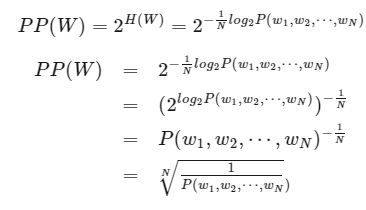

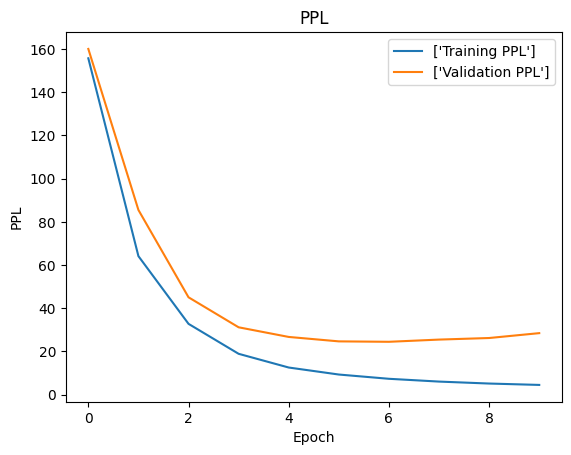

In [168]:
plt.plot(range(N_EPOCHS), tr_ppls, label=["Training PPL"])
plt.plot(range(N_EPOCHS), va_ppls, label=["Validation PPL"])
plt.ylabel("PPL")
plt.xlabel("Epoch")
plt.title("PPL")
plt.legend()

In [173]:
np.array(va_loss).argmin() + 1

7

7epoch에서 가장 낮은 validation loss 계산, 이 때의 weight를 tut3-model.pt에 저장한다.

Epoch: 07 | Time: 0m 38s
	Train Loss: 1.992 | Train PPL:   7.327
	 Val. Loss: 3.197 |  Val. PPL:  24.461

In [146]:
model.load_state_dict(torch.load('./checkpoint/tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.157 | Test PPL:  23.501 |


#### Translate

In [184]:
tr_iterator, va_iterator, te_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = 1,
    device = device)

for i, batch in enumerate(te_iterator):

    src = batch.src
    trg = batch.trg

    output = model(src, None, 0).squeeze(1) 
    translation_tensor = torch.argmax(output, 1) 
    translation = [TRG.vocab.itos[t] for t in translation_tensor][1:] 
    print(translation)
    print("\nTranslation Sentence")
    print(' '.join(translation))
    if i >= 0:
        break

['member', 'leaves', 'marx', 'sidewalks', 'chopping', 'grilling', 'wall', 'teeth', 'hid', 'rodeo', 'cooking', 'india', 'lay', 'john', 'grasping', 'balances', 'riders', 'american', 'railroad', 'mask', 'index', 'showers', 'van', 'razor']

Translation Sentence
member leaves marx sidewalks chopping grilling wall teeth hid rodeo cooking india lay john grasping balances riders american railroad mask index showers van razor


In [186]:
output.shape, output

(torch.Size([25, 5893]),
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.6447,  0.3384, -0.0285,  ...,  0.1194, -0.0038, -0.5607],
         [-0.3241,  0.0576, -0.1372,  ...,  0.0811,  0.2299, -0.3866],
         ...,
         [-0.0706, -0.6756, -0.2873,  ..., -0.2652,  0.0309, -0.1005],
         [-0.0257,  0.3613, -0.4284,  ..., -0.2276,  0.3563,  0.5163],
         [-0.3704,  0.4647, -0.0629,  ...,  0.0419, -0.3126, -0.6570]],
        device='cuda:1', grad_fn=<SqueezeBackward1>))

In [187]:
translation_tensor

tensor([   0, 1435,  513, 5268, 5616, 1995, 1195,  108,  845, 5105,  560,  461,
        2320, 1330, 1897, 2744, 1465, 1096,  327, 1095,  630, 4124, 5609,  809,
        2825], device='cuda:1')

In [176]:
candidate = ' '.join(vars(test_data.examples[0])['src'][::-1])
candidate_translation = ' '.join(vars(test_data.examples[0])['trg'])

print(candidate)
print(candidate_translation)

. anstarrt etwas der , hut orangefarbenen einem mit mann ein
a man in an orange hat starring at something .
